<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/01_foundations/W4_MAs_Final_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Moving Average Crossing Strategy

In this script I would like to analyze whicha re the performance of a simle trading strategy based on crossing moving averages. Differently from what we have done in the other analysis we will position ourselves on a shorter time frame

## Data and Libraries Importing

In [1]:
#importing main libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

## Functions for Data Processing

1. generate_signals(df, short_window, long_window): Adds shortEMA, longEMA, and position columns. Last position forced to 0 to close open trades.

2. compute_strategy_returns(df, slippage_pct, transaction_cost_pct, risk_free_rate): Uses position column to:

- Apply slippage and transaction costs.

- Inject the risk-free return when out of market.

- Compute the strategy return: final_strategy_return.

- Adds cumulative_strategy and cumulative_bnh.

3. strategy_metrics(df) Uses final_strategy_return as input return stream. It Calculates:

- Sharpe ratio

- Max Drawdown

- CAGR

- Number of Trades

- Win Rate

- Wins / Losses

In [2]:
#crossing MAs strategy
def simple_strategy(df, short_window, long_window):
    df = df.copy()[['close', 'volume']]

    df['shortEMA'] = df['close'].rolling(window=short_window).mean()
    df['longEMA'] = df['close'].rolling(window=long_window).mean()
    df['position'] = (df['shortEMA'] > df['longEMA']).astype(int)
    df.dropna(inplace=True)
    df.iloc[-1, df.columns.get_loc('position')] = 0 #force to clsoe trade at the end of teh simulation
    df.loc[df.index[0], 'position'] = 0  #force to be out of the market at the begining of the simualtion


    return df

In [89]:
def volatility_filter(df, vol_window, volatility_threshold):
    df['rolling_volatility'] = df['close'].pct_change().rolling(window=vol_window).std()  # 21 days = 1 month of trading days

    # Generate the volatility filter (0 or 1)
    df['volatility_filter'] = (df['rolling_volatility'] < volatility_threshold).astype(int)

    # Apply the volatility filter to position
    df['position'] *= df['volatility_filter']  # Only keep position if volatility is below the threshold
    df.dropna(inplace=True)
    return df


In [90]:
#creating the function to calculate the strategy returns
def compute_strategy_returns(df, slippage_pct, transaction_cost_pct):
    """
    Computes strategy returns given a position column, accounting for slippage, transaction costs, and risk-free rate.

    Parameters:
    - df: DataFrame with 'Close' and 'position' columns
    - slippage_pct: Slippage cost as a percentage (e.g., 0.002 for 0.2%)
    - transaction_cost_pct: Transaction cost per trade (e.g., 0.005 for 0.5%)
    - risk_free_rate: Daily return of risk-free asset (e.g., 0.0002)

    Returns:
    - df: DataFrame with added columns for strategy return and cumulative return
    """

    df = df.copy()
    df['daily_return'] = df['close'].squeeze().pct_change()
    df['position_change'] = df['position'].diff().fillna(0).ne(0).astype(int)
    df['slippage_flag'] = df['position_change']
    df['close_with_slippage'] = df['close'].squeeze() * (1 + slippage_pct * df['slippage_flag'])
    df['return_with_slippage'] = df['close_with_slippage'].pct_change() * df['position'].shift(1)
    df['transaction_cost'] = transaction_cost_pct * df['position_change']
    df['strategy_return_with_costs'] = df['return_with_slippage'] - df['transaction_cost']
    df['final_strategy_return'] = df['strategy_return_with_costs']
    df['cumulative_bnh'] = (1 + df['daily_return']).cumprod()
    df['cumulative_strategy'] = (1 + df['final_strategy_return']).cumprod()

    return df


In [91]:
def generate_trade_log(df):
    trade_log = []
    entry_date = None
    entry_price = None

    for i in range(1, len(df)):
        if df['position'].iloc[i-1] == 0 and df['position'].iloc[i] == 1:
            # Trade Entry
            entry_date = df.index[i]
            entry_price = df['close'].iloc[i]

        elif df['position'].iloc[i-1] == 1 and df['position'].iloc[i] == 0:
            # Trade Exit
            exit_date = df.index[i]
            exit_price = df['close'].iloc[i]

            if entry_date is not None and entry_price is not None:
                trade_return = (exit_price / entry_price) - 1
                trade_log.append({
                    'Entry Date': entry_date,
                    'Entry Price': entry_price,
                    'Exit Date': exit_date,
                    'Exit Price': exit_price,
                    'Trade Return': trade_return
                })

            # Reset
            entry_date = None
            entry_price = None

    return pd.DataFrame(trade_log)


In [92]:
def strategy_metrics(df):
    """
    Calculate key strategy metrics: Sharpe ratio, max drawdown, CAGR, win rate, and number of trades.

    Parameters:
    - df: DataFrame with strategy returns and other related data.

    Returns:
    - metrics: Dictionary containing key strategy metrics.
    """

    #calculate the total return (cumulative return)
    total_return = df['cumulative_strategy'].iloc[-1] - 1
    #calculate the maximum drawdown
    cumulative_max = df['cumulative_strategy'].cummax()
    drawdown = (df['cumulative_strategy'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    #Calculate the Sharpe ratio (annualized)
    daily_sharpe = df['final_strategy_return'].mean() / df['final_strategy_return'].std()
    annualized_sharpe = daily_sharpe * np.sqrt(252)
    # Compound Annual Growth Rate (CAGR)
    start_value = df['cumulative_strategy'].iloc[0]
    end_value = df['cumulative_strategy'].iloc[-1]
    years = (df.index[-1] - df.index[0]).days / 365
    cagr = (end_value / start_value) ** (1 / years) - 1
    #number of trades (position changes from 0 to 1 and 1 to 0)
    df['trade_signal'] = df['position'].diff()  # 1 when position changes
    num_trades = (df['trade_signal'] == 1).sum

    #all the metrics in a dictionary
    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'annualized_sharpe': annualized_sharpe,
        'cagr': cagr,
    }

    return metrics


In [93]:
def bnh_metrics(df):
    #calculate the total return (cumulative return)
    total_return = df['cumulative_bnh'].iloc[-1] - 1
    #calculate the maximum drawdown
    cumulative_max = df['cumulative_bnh'].cummax()
    drawdown = (df['cumulative_bnh'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    #Calculate the Sharpe ratio (annualized)
    daily_sharpe = df['daily_return'].mean() / df['daily_return'].std()
    annualized_sharpe = daily_sharpe * np.sqrt(252)
    # Compound Annual Growth Rate (CAGR)
    start_value = df['cumulative_bnh'].iloc[0]
    end_value = df['cumulative_bnh'].iloc[-1]
    years = (df.index[-1] - df.index[0]).days / 365
    cagr = (end_value / start_value) ** (1 / years) - 1

    #all the metrics in a dictionary
    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'annualized_sharpe': annualized_sharpe,
        'cagr': cagr,
    }

    return metrics



## Base Strategy

In [94]:
#defining the period of analysis
period = '5y'
#user inputed ticker selection for the analysis
print('You can select a stock you want to analyze using the ticker convention (e.g AAPL for Apple. GOOGL for Google, ...)')
tik = input('Select the ticker you want to analyze: ')
data = yf.download(tik, period=period, interval='1d')
data.columns = data.columns.get_level_values(0).str.lower()

You can select a stock you want to analyze using the ticker convention (e.g AAPL for Apple. GOOGL for Google, ...)
Select the ticker you want to analyze: ETH-USD


[*********************100%***********************]  1 of 1 completed


In [96]:
#user chosen moving averages
#shortMA = int(input('Select the short term MA (How many periods): '))
#longMA = int(input('Select the long term MA(How many periods): '))
#slippage_pct = float(input('Define the slippage as %: '))/100
#transaction_cost_pct = float(input('Define the transaction cost as %: '))/100
slippage_pct = 0.002
transaction_cost_pct = 0.005
shortMA = 50
longMA = 200
vol_window = 20
vol_threshold =0.02


In [101]:
#calling the strategy function
#calling the signal generator function
df = simple_strategy(data, shortMA, longMA)
#df = volatility_filter(df, vol_window, vol_threshold)
#df.loc[df.index[0], 'position'] = 0

In [104]:
df = compute_strategy_returns(df, slippage_pct, transaction_cost_pct)

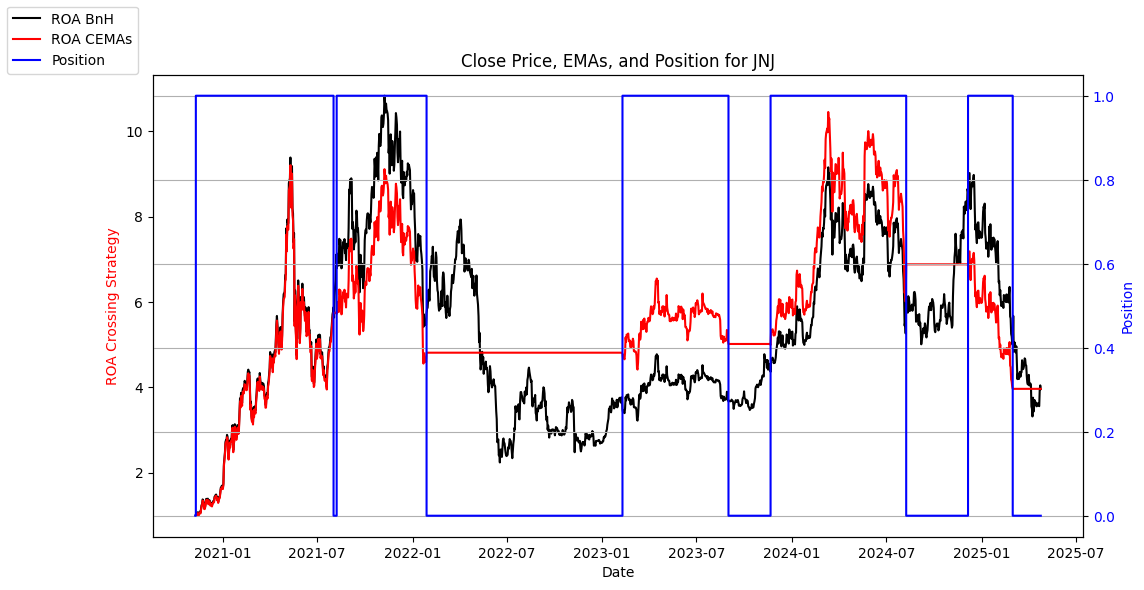

In [105]:
#visualize the cumulative returns evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

#ROA buy n hold
ax1.plot(df.index, df['cumulative_bnh'], label='ROA BnH', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Buy & Hold', color='black')
ax1.tick_params('y', labelcolor='black')
#ROA strategy
ax1.plot(df.index, df['cumulative_strategy'], label='ROA CEMAs', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Crossing Strategy', color='red')
ax1.tick_params('y', labelcolor='black')
#Position
ax2 = ax1.twinx()
ax2.step(df.index, df['position'], label='Position', color='blue', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='blue')
ax2.tick_params('y', labelcolor='blue')

plt.title('Close Price, EMAs, and Position for JNJ')
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

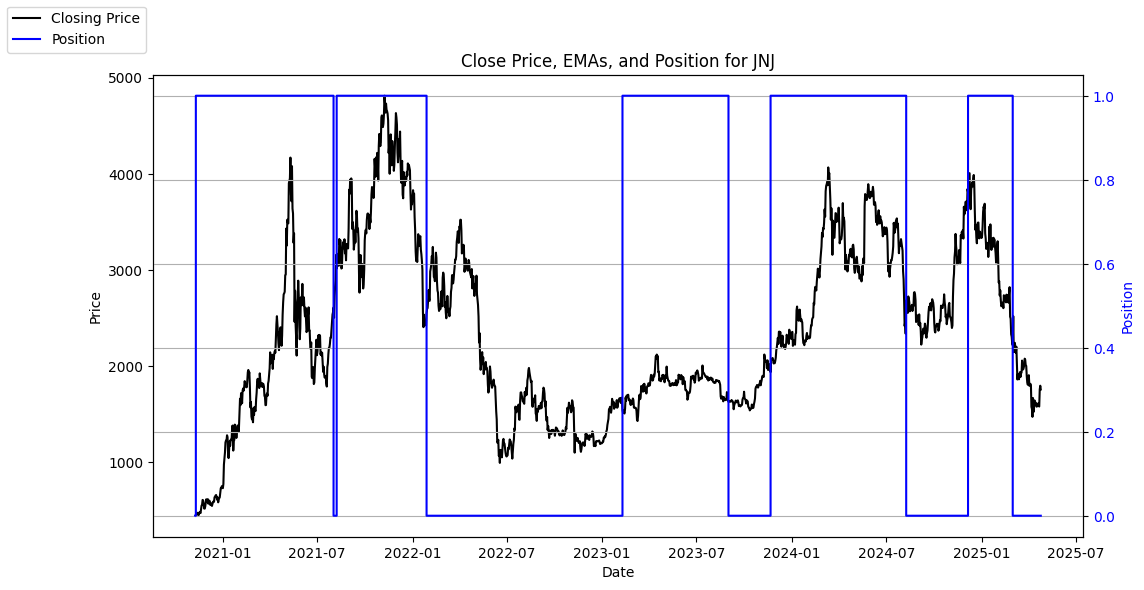

In [106]:
#visualize the price evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

#Price
ax1.plot(df.index, df['close'], label='Closing Price', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='black')
ax1.tick_params('y', labelcolor='black')
#Position
ax2 = ax1.twinx()
ax2.step(df.index, df['position'], label='Position', color='blue', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='blue')
ax2.tick_params('y', labelcolor='blue')

plt.title('Close Price, EMAs, and Position for JNJ')
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

In [44]:
metrics_strategy = strategy_metrics(df)
metrics_bnh = bnh_metrics(df)
#recalculating the cagr there is an errors in the function
years = int(period.split('y')[0])
metrics_bnh['cagr'] = (1+metrics_bnh['total_return'])**(1/years)-1
metrics_strategy['cagr'] = (1+metrics_strategy['total_return'])**(1/years)-1

In [109]:
trade_log = generate_trade_log(df)
trade_log

,Entry Date,Entry Price,Exit Date,Exit Price,Trade Return
0,2020-11-10,449.679626,2021-08-02,2610.153320,4.804473
1,2021-08-08,3013.732666,2022-01-28,2547.092041,-0.154838
2,2023-02-09,1546.438232,2023-09-01,1628.491211,0.053059
3,2023-11-21,1937.066772,2024-08-08,2683.352783,0.385266
4,2024-12-05,3811.008301,2025-03-01,2216.643311,-0.418358


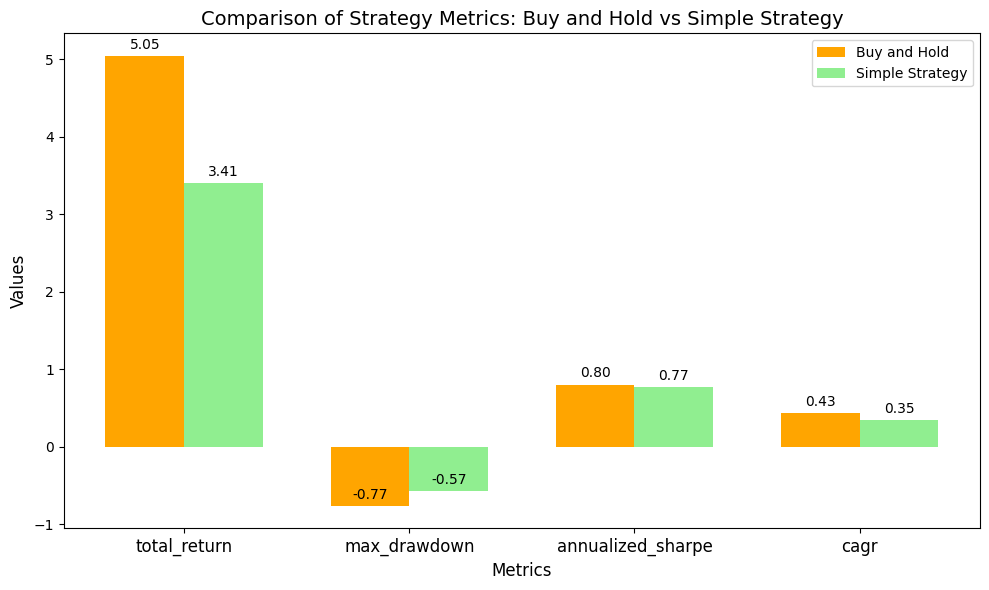

In [123]:
# Extract the values for plotting
metrics = ['total_return', 'max_drawdown', 'annualized_sharpe', 'cagr']
bnh_values = [metrics_bnh[m] for m in metrics]
strategy_values = [metrics_strategy[m] for m in metrics]

# Create a bar chart to compare the metrics
x = np.arange(len(metrics))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Buy and Hold and Strategy
bars_bnh = ax.bar(x - width/2, bnh_values, width, label='Buy and Hold', color='orange')
bars_strategy = ax.bar(x + width/2, strategy_values, width, label='Simple Strategy', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('Comparison of Strategy Metrics: Buy and Hold vs Simple Strategy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend()

# Display the values on top of the bars for clarity
def add_values(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{value:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(bars_bnh, bnh_values)
add_values(bars_strategy, strategy_values)

fig.tight_layout()

plt.show()


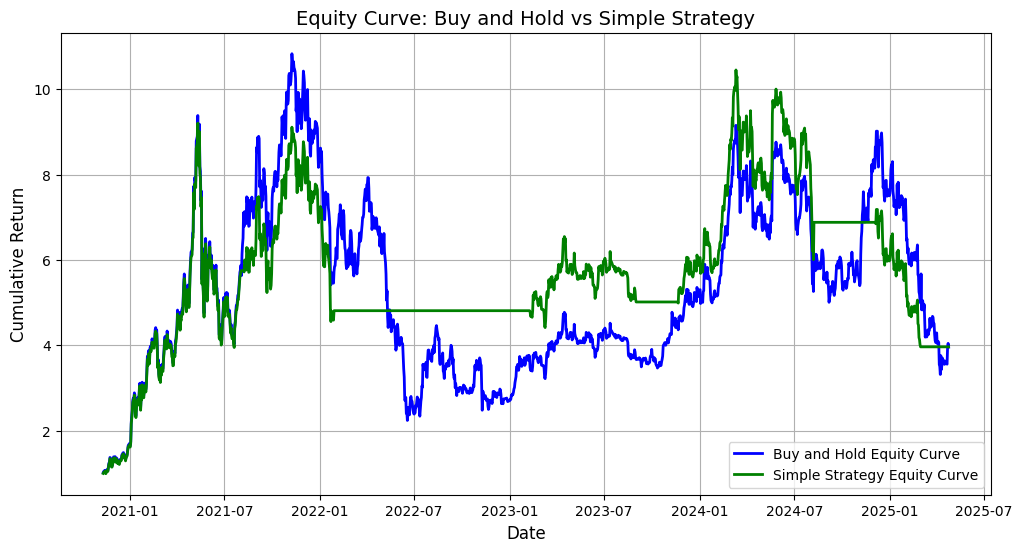

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_bnh'], label='Buy and Hold Equity Curve', color='blue', linewidth=2)
plt.plot(df['cumulative_strategy'], label='Simple Strategy Equity Curve', color='green', linewidth=2)
plt.title('Equity Curve: Buy and Hold vs Simple Strategy', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
